In [1]:
import os.path as osp
import sys
path = osp.dirname(osp.abspath(''))
sys.path.append(path)
sys.path.append(osp.join(path, "open_biomed"))
path

'/AIRvePFS/dair/luoyz-data/Open_DAIR_BioMed'

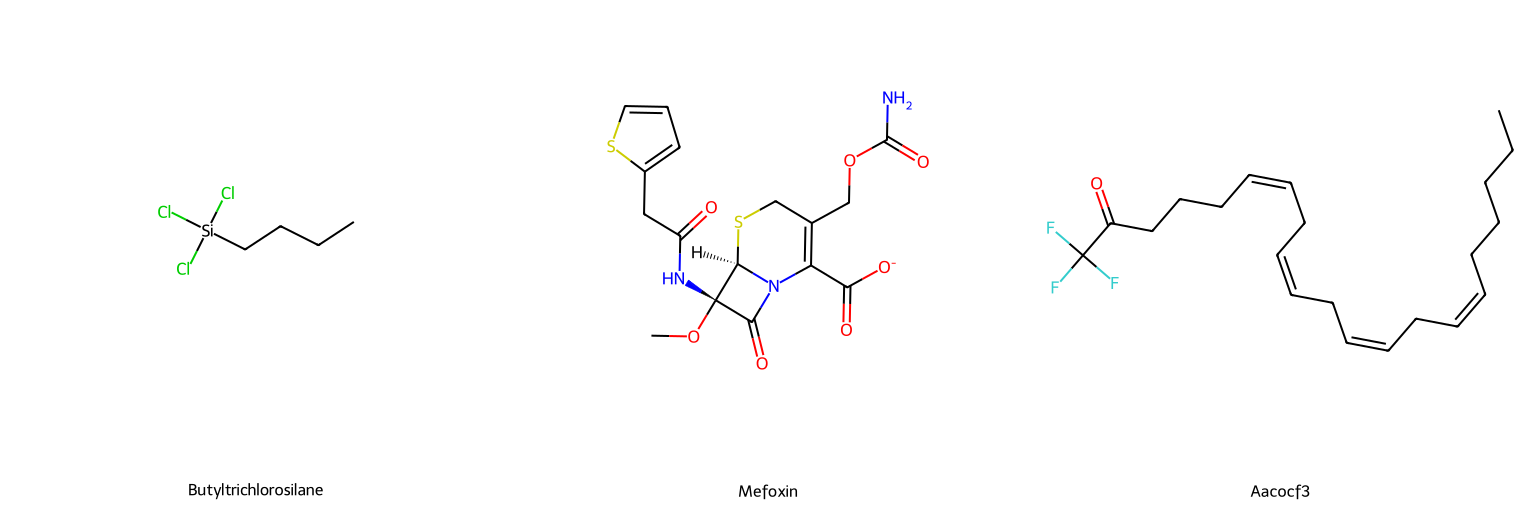

In [2]:
smis = [
    "CCCC[Si](Cl)(Cl)Cl", 
    "CO[C@@]1([C@@H]2N(C1=O)C(=C(CS2)COC(=O)N)C(=O)[O-])NC(=O)CC3=CC=CS3", 
    "CCCCC/C=C\C/C=C\C/C=C\C/C=C\CCCC(=O)C(F)(F)F",
]
texts = [
    "it appears as a colorless liquid with a pungent odor. Flash point 126Â°F. Corrosive to metals and skin. Used to make various silicon containing compounds.",
    "it is a cephalosporin carboxylic acid anion having methoxy, 2-thienylacetamido and carbamoyloxymethyl side-groups, formed by proton loss from the carboxy group of the semisynthetic cephamycin antibiotic cefoxitin. It is a conjugate base of a cefoxitin.",
    "it is a fatty acid derivative that is arachidonic acid in which the OH part of the carboxy group has been replaced by a trifluoromethyl group It has a role as an EC 3.1.1.4 (phospholipase A2) inhibitor. It is an organofluorine compound, a ketone, an olefinic compound and a fatty acid derivative. It derives from an arachidonic acid.",
]

from rdkit import Chem
from rdkit.Chem import Draw
mols = [Chem.MolFromSmiles(smi) for smi in smis]
Draw.MolsToGridImage(mols, legends=["Butyltrichlorosilane", "Mefoxin", "Aacocf3"], molsPerRow=3, subImgSize=(512, 512))


In [3]:
# prepare data
import json
from open_biomed.utils.data_utils import DataProcessorFast
from open_biomed.utils import fix_path_in_config

config = json.load(open("../configs/mtr/molfm.json", "r"))
fix_path_in_config(config, path)
print("Config: ", config)
processor = DataProcessorFast(entity_type="molecule", config=config["data"]["mol"])
processor.featurizer.set_mol2text_dict(dict(zip(smis, texts)))
mols = processor(smis)

/AIRvePFS/dair/luoyz-data/anaconda3/envs/biomedgpt/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Config:  {'model': 'molfm', 'data': {'mol': {'modality': ['structure', 'text'], 'featurizer': {'structure': {'name': 'BaseGNN'}, 'text': {'name': 'TransformerTokenizer', 'transformer_type': 'bert', 'max_length': 128, 'model_name_or_path': '/AIRvePFS/dair/luoyz-data/Open_DAIR_BioMed/ckpts/text_ckpts/scibert_scivocab_uncased'}}}}, 'network': {'gin_hidden_dim': 300, 'gin_num_layers': 5, 'drop_ratio': 0.0, 'bert_config_path': '/AIRvePFS/dair/luoyz-data/Open_DAIR_BioMed/configs/encoders/multimodal/molfm_bert_config.json', 'max_n_nodes': 128, 'projection_dim': 256, 'kge': {'n_ents': 49151, 'n_rels': 16, 'norm': 2, 'hidden_size': 256, 'margin': 2.0}}}


In [4]:
import torch
from open_biomed.models.multimodal import MolFM
model = MolFM(config["network"])
state_dict = torch.load("../ckpts/fusion_ckpts/molfm.pth", map_location="cpu")["model"]
model.load_state_dict(state_dict)
model.eval()

with torch.no_grad():
    structure_feats = model.encode_mol(mols["structure"], proj=True)
    text_feats = model.encode_text(mols["text"])

for i in range(len(smis)):
    similarity = torch.cosine_similarity(structure_feats[i], text_feats)
    best = torch.argmax(similarity).item()
    print("Similarity for ", smis[i], "is", similarity.numpy(), ", Retrieved text is \"", texts[best], "\"")

Similarity for  CCCC[Si](Cl)(Cl)Cl is [ 0.40700457 -0.1139261  -0.04660066] , Retrieved text is " it appears as a colorless liquid with a pungent odor. Flash point 126Â°F. Corrosive to metals and skin. Used to make various silicon containing compounds. "
Similarity for  CO[C@@]1([C@@H]2N(C1=O)C(=C(CS2)COC(=O)N)C(=O)[O-])NC(=O)CC3=CC=CS3 is [-0.10423345  0.75913167  0.04899469] , Retrieved text is " it is a cephalosporin carboxylic acid anion having methoxy, 2-thienylacetamido and carbamoyloxymethyl side-groups, formed by proton loss from the carboxy group of the semisynthetic cephamycin antibiotic cefoxitin. It is a conjugate base of a cefoxitin. "
Similarity for  CCCCC/C=C\C/C=C\C/C=C\C/C=C\CCCC(=O)C(F)(F)F is [0.13956559 0.10620868 0.60520554] , Retrieved text is " it is a fatty acid derivative that is arachidonic acid in which the OH part of the carboxy group has been replaced by a trifluoromethyl group It has a role as an EC 3.1.1.4 (phospholipase A2) inhibitor. It is an organofluo